## 時系列モデルの種類
時系列予測: 何かしらの法則・周期があれば未来を予測できる
その代表が以下のモデル(全てではない)

#モデル選定が一番時間がかかる

- AR（自己回帰モデル）: 現在の値は、過去の値から決まる
- MA（移動平均モデル）: 現在の値は、過去の「実績と予測のズレ」から決まる
- ARMA（自己回帰 移動平均モデル） ...AR + MA
- ARIMA（自己回帰 和分 移動平均モデル） ...ARMA + I(時間帯によって平均値はブレる)
- ★ SARIMA（季節 自己回帰 和分 移動平均モデル） ...S(データに周期性がある) + ARIMA
- ★ SARIMAX ...SARIMA + 説明変数 (自分以外の情報(データ)も踏まえて予測したい)

モデリングはシンプルで済む方がいい -> ★がおすすめ

以下は統計モデリング(「データが生まれた背景を知ること」が目的)

1. AR (AutoRegressive):
ARモデルは、自己回帰モデルとも呼ばれ、過去のラグされた（過去の時間ステップの）データが現在のデータに影響を与えるモデルです。単純なAR(1)モデルは、1つ前の時点のデータの影響を考慮するものです。AR(p)モデルでは、p個前の時点までのデータが影響を与えます。

2. MA (Moving Average):
MAモデルは、移動平均モデルとも呼ばれ、過去の誤差項（ノイズ）の加重平均が現在のデータに影響を与えるモデルです。単純なMA(1)モデルは、1つ前の誤差項の影響を考慮するものです。MA(q)モデルでは、q個前の誤差項までを考慮します。

3. ARMA (AutoRegressive Moving Average):
ARMAモデルは、ARモデルとMAモデルを組み合わせたもので、過去のデータと誤差項の両方が現在のデータに影響を与えるモデルです。ARMA(p, q)モデルは、p次の自己回帰とq次の移動平均を持ちます。

4. ARIMA (AutoRegressive Integrated Moving Average):
ARIMAモデルは、ARモデルとMAモデルを差分を取って整合化し、トレンドや季節性をモデル化するために使用されます。ARIMA(p, d, q)モデルで、pは自己回帰次数、dは差分を取る回数、qは移動平均次数を表します。

5. SARIMA (Seasonal AutoRegressive Integrated Moving Average):
SARIMAモデルは、ARIMAモデルに季節性成分を追加したモデルです。季節性が強調された時系列データに適しています。SARIMA(p, d, q)(P, D, Q, s)モデルでは、通常のARIMAモデルのパラメータに加えて、季節性成分のパラメータも含まれます。P、D、Qは季節性成分の自己回帰、差分、移動平均の次数で、sは季節性の周期を表します。

6. SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous factors):SARIMAXモデルは、SARIMAモデルに外部の説明変数（exogenous factors）を追加したモデルです。外部変数を考慮して時系列データをモデル化し、予測します。外部変数は季節性やトレンドの影響を説明するのに役立ちます。




In [1]:
# https://www.youtube.com/watch?v=bLd9s9DtDbE&list=PL_tQOEJCWOE5aTQDXRm3Y3LY_s4gu2ALb&index=4
# https://analysis-navi.com/?p=3868#google_vignette

import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

#データ読み込み
df = pd.read_csv("3-2_TS_sample2.csv",index_col="年月日",encoding="shift_jis",parse_dates=True)

# インデックス名を英語にリネーム
df.rename_axis('Date', axis=0, inplace=True)

# 列名を英語にリネーム
new_columns = {
    '平均気温(℃)': 'Average Temperature (℃)',
    '降水量の合計(mm)': 'Total Precipitation (mm)',
    '日照時間(時間)': 'Sunshine Duration (hours)',
    '曜日': 'Day of the Week'
}

df.rename(columns=new_columns, inplace=True)

In [2]:
df

,Average Temperature (℃),Total Precipitation (mm),Sunshine Duration (hours)
Date,,,
2010-01-01,4.8,0.0,9.2
2010-01-02,6.3,0.0,9.0
2010-01-03,5.7,0.0,6.6
2010-01-04,6.5,0.0,5.2
2010-01-05,7.3,2.5,8.1
...,...,...,...
2019-12-27,8.7,0.5,6.5
2019-12-28,6.8,0.0,8.8
2019-12-29,7.0,0.0,8.3


### AR,MA,ARMA

In [3]:
#statsmodelsのバージョンは0.8.0以降にしましょう
#(コマンド)conda install -c taugspurger statsmodels=0.8.0
# statsmodels.api as sm: 統計モデル作成にも使われる
import statsmodels.api as sm

y = df["Average Temperature (℃)"]
# AIC(BIC)が低くなるようにorder=(3,0,1)を調整する必要がある -> ARMAモデルの最適パラメータ推定を使用する(sm.tsa.arma_order_select_ic(df["Average Temperature (℃)"],ic='aic'))
# freq="D": dfのデータが日毎(1日ごと)だから"D"の設定, 月であれば"M"
# arma_model = sm.tsa.ARMA(y, order=(3, 0),freq="D"): AR(3)のモデルを作成できる
# arma_model = sm.tsa.ARMA(y, order=(0, 1),freq="D"): MA(1)のモデルを作成できる
# 新しいバージョンの statsmodels では、ARMA モデルは ARIMA モデルを使って構築されるようになりました。
# このコードでは、ARIMA モデルを使って ARMA(3, 1) モデルを構築しています。ARIMA モデルの order パラメータで p=3（AR次数）、d=0（差分次数）、q=1（MA次数）を指定しています。
arma_model = sm.tsa.ARIMA(y, order=(3,0,1),freq="D")
result = arma_model.fit()

result.summary() #ここで表示される数値を見ても治しようがない(arやmaの部分) -> ここは考察が難しい?
# AIC(BIC)を見るのが大事, 低ければ低いほどいい

# AIC(BIC)を見るのが大事で低ければ低いほどいいと言われたんだけど、低い場合って過学習とかないの?
# AIC（赤池情報量基準）およびBIC（ベイズ情報量基準）は、統計モデルの適合度とモデルの複雑さのトレードオフを考慮しています。
# これらの基準は、適合度を最大化する一方で、モデルの複雑さにペナルティを課すことによって、過学習（モデルがトレーニングデータに過度に適合すること）を防ぐためのツールとして使用されます。
# したがって、AICとBICが低いほど、モデルの適合度と複雑さのトレードオフがうまく調整され、過学習のリスクが低いと言えます。
# ただし、AICやBICが低いからといって必ずしも過学習を回避できるわけではありません。これらの基準はあくまで一つのガイドラインであり、過学習を防ぐためには他の手法やモデル選択のプロセスと組み合わせて考える必要があります。
# 例えば、クロスバリデーションを行ったり、モデルの複雑性を調整するための正則化を導入したりすることで、過学習のリスクを低減できます。
# 要するに、AICやBICはモデル選択において重要な指標ですが、それだけでなく、過学習を回避するために他の方法と組み合わせて利用することが推奨されます。モデル選択は常にデータと問題の特性に合わせて検討する必要があります。

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Average Temperature (℃)   No. Observations:                 3652
Model:                      ARIMA(3, 0, 1)   Log Likelihood               -7687.144
Date:                     Sun, 24 Sep 2023   AIC                          15386.289
Time:                             07:57:16   BIC                          15423.507
Sample:                         01-01-2010   HQIC                         15399.543
                              - 12-31-2019                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.4991      2.646      5.857      0.000      10.313      20.685
ar.L1          1.6011      0.024     67.048      0.000       1.554       1.648
ar.L2         -0.7565      0.028    -26.626      0.000      -0.812      -0.701
ar.L3          0.1529      0.016      9.288      0.000       0.121       0.185
ma.L1         -0.7947      0.020    -40.244      0.000      -0.833      -0.756
sigma2         3.9395      0.082     48.137      0.000       3.779       4.100
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               180.51
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.33
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [4]:
# ARMAモデルの最適パラメータ推定
# ic='aic': 最適化したい指標
sm.tsa.arma_order_select_ic(df["Average Temperature (℃)"], ic='aic')

# 'aic_min_order': (3, 1): 今回の最適解
# 予測のためににはいいモデルである必要があるため規則性によく当てはまるモデルを作成する必要がある

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'aic':               0             1             2
 0  25653.397308  21825.923163  19726.214444
 1  15770.002959  15738.492487  15455.775907
 2  15753.635867  15771.721170  15386.937673
 3  15594.912152  15386.288950  15388.064007
 4  15544.891242  15388.253342  15389.071286,
 'aic_min_order': (3, 1)}

### ARIMA、SARIMA、SARIMAX

In [5]:
#　月ごとに集計したデータも準備しておく(日毎だとうるう年の影響があるため月毎にした)
df_month = df["2010":"2018"].resample("M").mean()
df_month_all = df["2010":"2019"].resample("M").mean()

df_month_pred = df["2019"].resample("M").mean()

<ipython-input-5-36f793ed0e8a>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df_month_pred = df["2019"].resample("M").mean()


In [6]:
# SARIMA ver
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = df_month["Average Temperature (℃)"]
# X = df_month[["Total Precipitation (mm)","Sunshine Duration (hours)"]] #これがないとSARIMAになる -> あるとSARIMAX(Xという説明変数が追加されるから)
sarima_model = sm.tsa.SARIMAX(y, order=(1,1,1),seasonal_order=(0,1,1,12))  #SARIMAXにする場合はXの変数を入れる必要がある
result = sarima_model.fit()

result.summary()

# sarima_model = sm.tsa.SARIMAX(y,X, order=(1,1,1)): これだとARIMAモデルになる(SeasonとeXogenousの指定がないから)
# sarima_model = sm.tsa.SARIMAX(y, order=(1,1,1),seasonal_order=(0,1,1,12)): これだとSARIMAになる(eXogenousの指定がないから)
# seasonal_order=(0,1,1,12): order=(1,1,1)の部分とseasonal_order=(0,1,1)は同じだけど、seasonal_order=(0,1,1)は季節変動に対してのパラメータ
# 12の部分は周期性がいくつか: 月ごとであるから12に指定している -> このパラメータの設定は難しくない
# order=(1,1,1)の真ん中は1であることが多いらしい
# つまりパラメータとしてはorder=(_,1,_), seasonal_order=(_,_,_,12)の5つのパラメータが大事, 12の適宜変更する -> ARIMA以降だと最適化するパラメータはないからグリッドサーチを適用する

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Average Temperature (℃)   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -147.015
Date:                            Sun, 24 Sep 2023   AIC                            302.030
Time:                                    07:58:26   BIC                            312.246
Sample:                                01-31-2010   HQIC                           306.158
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2760      0.117      2.351      0.019       0.046       0.506
ma.L1         -0.9993      2.520     -0.397      0.692      -5.938       3.940
ma.S.L12      -0.6992      0.141     -4.968      0.000      -0.975      -0.423
sigma2         1.1204      2.845      0.394      0.694      -4.456       6.697
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 1.26
Prob(Q):                              0.79   Prob(JB):                         0.53
Heteroskedasticity (H):               0.91   Skew:                             0.23
Prob(H) (two-sided):                  0.79   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### グリッドサーチ

In [7]:
import itertools
# 季節性の次数の候補として使用するパラメータ
p = q = range(0, 3) #p:AR, q:MAを0~2の範囲で探索(まずは少ない範囲から探索する)
sp = sd = sq = range(0, 2) #0~2の範囲で探索(季節の周期性)

#p,q,sp,sd,sqの組み合わせのリストを作成する。和分=1,周期=12は固定
pdq = [(x[0], 1, x[1]) for x in list(itertools.product(p, q))] # list(itertools.product(p, q))
# pdq = [(x[0], 1, x[1]) #1で固定している, x[0](AR), x[1](MA)だけでp = q = range(0, 3)で全パターンの組み合わせが作成できる(今回は9パターン)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(sp, sd, sq))]
# こちらも同上(今回は8パターン)

In [8]:
import warnings
warnings.filterwarnings("ignore") #0で割ったり、logの中が0になった時にwarningsが出ると行数が多くなるから無視する必要がある

best_result = [0, 0, 10000000]

# パラメータの組み合わせを試行
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # SARIMAモデルの構築とフィット
            mod = SARIMAX(y, order = param, seasonal_order = param_seasonal) #SARIMAだからXは必要ない
            results = mod.fit()
            print('ARIMA parameter{}, Seasonal variation parameters{} - AIC: {}'.format(param, param_seasonal, results.aic))

            if results.aic < best_result[2]:
                # param: ARとMA
                # param_seasonal: sp = sd = sq(季節の周期性)
                # results.aic: 上記の時のAIC
                # 最初の10000000と比較して、results.aicが低ければ更新する(パラメータに対してaicが最小であるのものを更新していく) ->  現在のAICが過去の最小AICより小さい場合、最適なパラメータを更新
                best_result = [param, param_seasonal, results.aic]
        except:
            continue #計算をtryしてできない場合はcontinue(skip)する -> エラーが発生した場合はスキップ

# 最適なモデルのパラメータとAICを表示
print('AIC min model：', best_result) #printで状況がわかる, 今回は8*9 = 72パターン
# あまり探索範囲が広いと計算が終わらなくなる -> 探索してもp = q = range(0, 3~5)まで -> まあ3で十分
# 今回のベストパラメータ: AIC min model： [(1, 1, 1), (0, 1, 1, 12), 302.03042292995497]

ARIMA parameter(0, 1, 0), Seasonal variation parameters(0, 0, 0, 12) - AIC: 613.9551631312182
ARIMA parameter(0, 1, 0), Seasonal variation parameters(0, 0, 1, 12) - AIC: 528.8431052176811
ARIMA parameter(0, 1, 0), Seasonal variation parameters(0, 1, 0, 12) - AIC: 359.2434101619832
ARIMA parameter(0, 1, 0), Seasonal variation parameters(0, 1, 1, 12) - AIC: 333.3739289152234
ARIMA parameter(0, 1, 0), Seasonal variation parameters(1, 0, 0, 12) - AIC: 427.04786255736025
ARIMA parameter(0, 1, 0), Seasonal variation parameters(1, 0, 1, 12) - AIC: 403.0699595455103
ARIMA parameter(0, 1, 0), Seasonal variation parameters(1, 1, 0, 12) - AIC: 351.6899032331263
ARIMA parameter(0, 1, 0), Seasonal variation parameters(1, 1, 1, 12) - AIC: 334.5502668441836
ARIMA parameter(0, 1, 1), Seasonal variation parameters(0, 0, 0, 12) - AIC: 560.8256802210583
ARIMA parameter(0, 1, 1), Seasonal variation parameters(0, 0, 1, 12) - AIC: 505.98269281990616
ARIMA parameter(0, 1, 1), Seasonal variation parameters(0,

### ホワイトノイズの確認

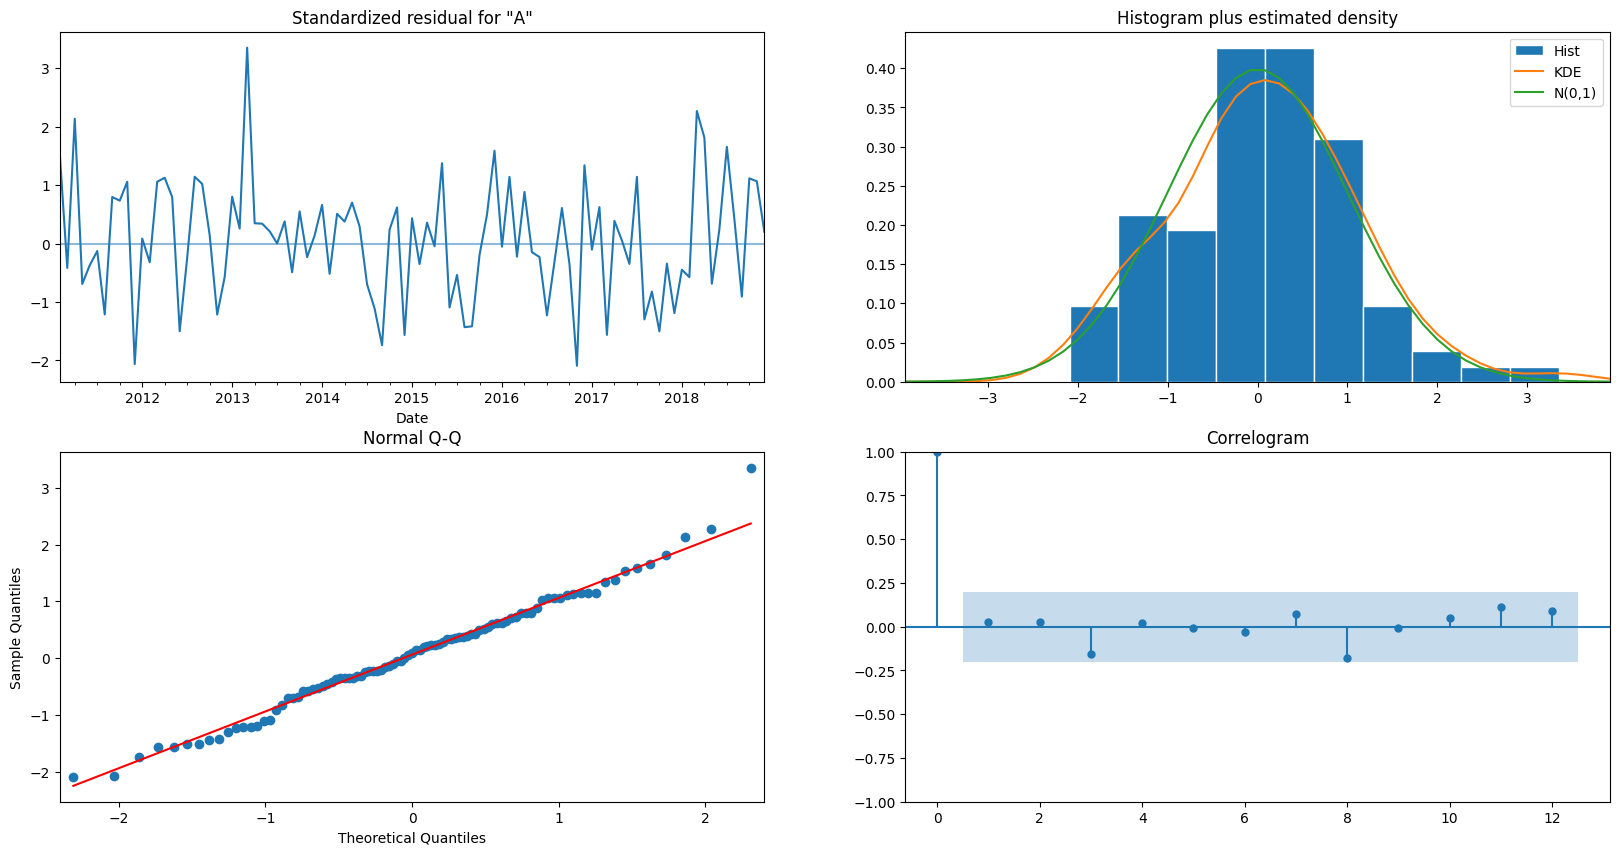

In [9]:
plt.rc("figure",figsize=(20,10))
result.plot_diagnostics(lags=12); #ノイズの確認

In [10]:
# SARIMAX ver
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = df_month["Average Temperature (℃)"]
X = df_month[["Total Precipitation (mm)","Sunshine Duration (hours)"]] #これがあることでSARIMAXになる
sarima_model = sm.tsa.SARIMAX(y,X, order=(1,1,1),seasonal_order=(0,1,1,12)) #SARIMAXにする場合はXの変数を入れる必要がある
result = sarima_model.fit()

result.summary() # 説明変数の部分は解釈できる(Total Precipitation (mm)と)Sunshine Duration (hours)
#Sunshine Duration (hours)はAverage Temperature (℃)と関連があることがP値を見て確認できる(優位である)

# sarima_model = sm.tsa.SARIMAX(y,X, order=(1,1,1)): これだとARIMAモデルになる(SeasonとeXogenousの指定がないから)
# sarima_model = sm.tsa.SARIMAX(y,X, order=(1,1,1),seasonal_order=(0,1,1,12)): これだとSARIMAになる
# seasonal_order=(0,1,1,12): order=(1,1,1)の部分とseasonal_order=(0,1,1)は同じだけど、seasonal_order=(0,1,1)は季節変動に対してのパラメータ
# 12の部分は周期性がいくつか: 月ごとであるから12に指定している -> このパラメータの設定は難しくない
# order=(1,1,1)の真ん中は1であることが多いらしい
# つまりパラメータとしてはorder=(_,1,_), seasonal_order=(_,_,_,12)の5つのパラメータが大事, 12の適宜変更する -> ARIMA以降だと最適化するパラメータはないからグリッドサーチを適用する

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Average Temperature (℃)   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -141.757
Date:                            Sun, 24 Sep 2023   AIC                            295.513
Time:                                    07:59:20   BIC                            310.837
Sample:                                01-31-2010   HQIC                           301.705
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Total Precipitation (mm)     -0.0053      0.036     -0.145      0.885      -0.077       0.066
Sunshine Duration (hours)     0.3840      0.154      2.489      0.013       0.082       0.686
ar.L1                         0.2493      0.119      2.102      0.036       0.017       0.482
ma.L1                        -0.9992      2.905     -0.344      0.731      -6.694       4.695
ma.S.L12                     -0.9979     14.986     -0.067      0.947     -30.371      28.375
sigma2                        0.8251     13.427      0.061      0.951     -25.491      27.142
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 1.97
Prob(Q):                              0.79   Prob(JB):                         0.37
Heteroskedasticity (H):               0.89   Skew:                             0.31
Prob(H) (two-sided):                  0.74   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### グリッドサーチ

In [11]:
import itertools
# 季節性の次数の候補として使用するパラメータ
p = q = range(0, 3) #p:AR, q:MAを0~2の範囲で探索(まずは少ない範囲から探索する)
sp = sd = sq = range(0, 2) #0~2の範囲で探索(季節の周期性)

#p,q,sp,sd,sqの組み合わせのリストを作成する。和分=1,周期=12は固定
pdq = [(x[0], 1, x[1]) for x in list(itertools.product(p, q))] # list(itertools.product(p, q))
# pdq = [(x[0], 1, x[1]) #1で固定している, x[0](AR), x[1](MA)だけでp = q = range(0, 3)で全パターンの組み合わせが作成できる(今回は9パターン)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(sp, sd, sq))]
# こちらも同上(今回は8パターン)

In [12]:
import warnings
warnings.filterwarnings("ignore") #0で割ったり、logの中が0になった時にwarningsが出ると行数が多くなるから無視する必要がある

best_result = [0, 0, 10000000]

# パラメータの組み合わせを試行
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # SARIMAモデルの構築とフィット
            mod = SARIMAX(y, X, order = param, seasonal_order = param_seasonal) #SARIMAXだからX(説明変数)を追加する必要がある -> 今回はこのモデルが良さそう
            results = mod.fit()
            print('ARIMA parameter{}, Seasonal variation parameters{} - AIC: {}'.format(param, param_seasonal, results.aic))

            if results.aic < best_result[2]:
                # param: ARとMA
                # param_seasonal: sp = sd = sq(季節の周期性)
                # results.aic: 上記の時のAIC
                # 最初の10000000と比較して、results.aicが低ければ更新する(パラメータに対してaicが最小であるのものを更新していく) ->  現在のAICが過去の最小AICより小さい場合、最適なパラメータを更新
                best_result = [param, param_seasonal, results.aic]
        except:
            continue #計算をtryしてできない場合はcontinue(skip)する -> エラーが発生した場合はスキップ

# 最適なモデルのパラメータとAICを表示
print('AIC min model：', best_result) #printで状況がわかる, 今回は8*9 = 72パターン
# あまり探索範囲が広いと計算が終わらなくなる -> 探索してもp = q = range(0, 3~5)まで -> まあ3で十分
# 今回のベストパラメータ: AIC min model： [(1, 1, 1), (0, 1, 1, 12), 295.5133865219296] -> X（説明変数）があるほうが予測精度が高い

ARIMA parameter(0, 1, 0), Seasonal variation parameters(0, 0, 0, 12) - AIC: 616.0429916950098
ARIMA parameter(0, 1, 0), Seasonal variation parameters(0, 0, 1, 12) - AIC: 528.1750984530375
ARIMA parameter(0, 1, 0), Seasonal variation parameters(0, 1, 0, 12) - AIC: 359.31885521794646
ARIMA parameter(0, 1, 0), Seasonal variation parameters(0, 1, 1, 12) - AIC: 329.0862128787359
ARIMA parameter(0, 1, 0), Seasonal variation parameters(1, 0, 0, 12) - AIC: 426.9398359744693
ARIMA parameter(0, 1, 0), Seasonal variation parameters(1, 0, 1, 12) - AIC: 398.9831155181724
ARIMA parameter(0, 1, 0), Seasonal variation parameters(1, 1, 0, 12) - AIC: 351.63290450870943
ARIMA parameter(0, 1, 0), Seasonal variation parameters(1, 1, 1, 12) - AIC: 330.8639636036156
ARIMA parameter(0, 1, 1), Seasonal variation parameters(0, 0, 0, 12) - AIC: 558.4385104552983
ARIMA parameter(0, 1, 1), Seasonal variation parameters(0, 0, 1, 12) - AIC: 498.2884600132486
ARIMA parameter(0, 1, 1), Seasonal variation parameters(0,

### ホワイトノイズの確認

ホワイトノイズ（White Noise）は、統計学や信号処理などの分野で重要な概念であり、ランダムなデータや信号の特性を表現するために使用されます。以下はホワイトノイズに関する重要な特徴です。

* ランダム性: ホワイトノイズはランダムなデータまたは信号です。つまり、時間や空間に関して予測不可能で、ランダムな変動が含まれています。

* 平均値: ホワイトノイズの平均値はゼロです。つまり、長期的な平均がゼロであるという特性があります。
一様な分散: ホワイトノイズの各データポイント（サンプル）は同じ分散（ばらつき）を持ちます。つまり、各データポイントのばらつきが均一であり、時間や位置による変動がありません。

* 無相関性: ホワイトノイズの異なる時間または位置のデータポイントは無相関です。つまり、1つのデータポイントの値から他のデータポイントの値を予測することはできません。相関がないことが特徴です。

* 連続性: ホワイトノイズは連続的なデータや信号であり、データポイント間の時間または空間の間隔が一定です。

ホワイトノイズは、ランダムな要素が含まれているため、実世界の多くの現象をモデル化するのに役立ちます。また、統計モデルの診断、シミュレーション、信号処理、フィルタリングなど、さまざまなアプリケーションで使用されます。ホワイトノイズの性質に基づいて、その他の時系列データや信号を解析したり、モデル化したりすることができます。

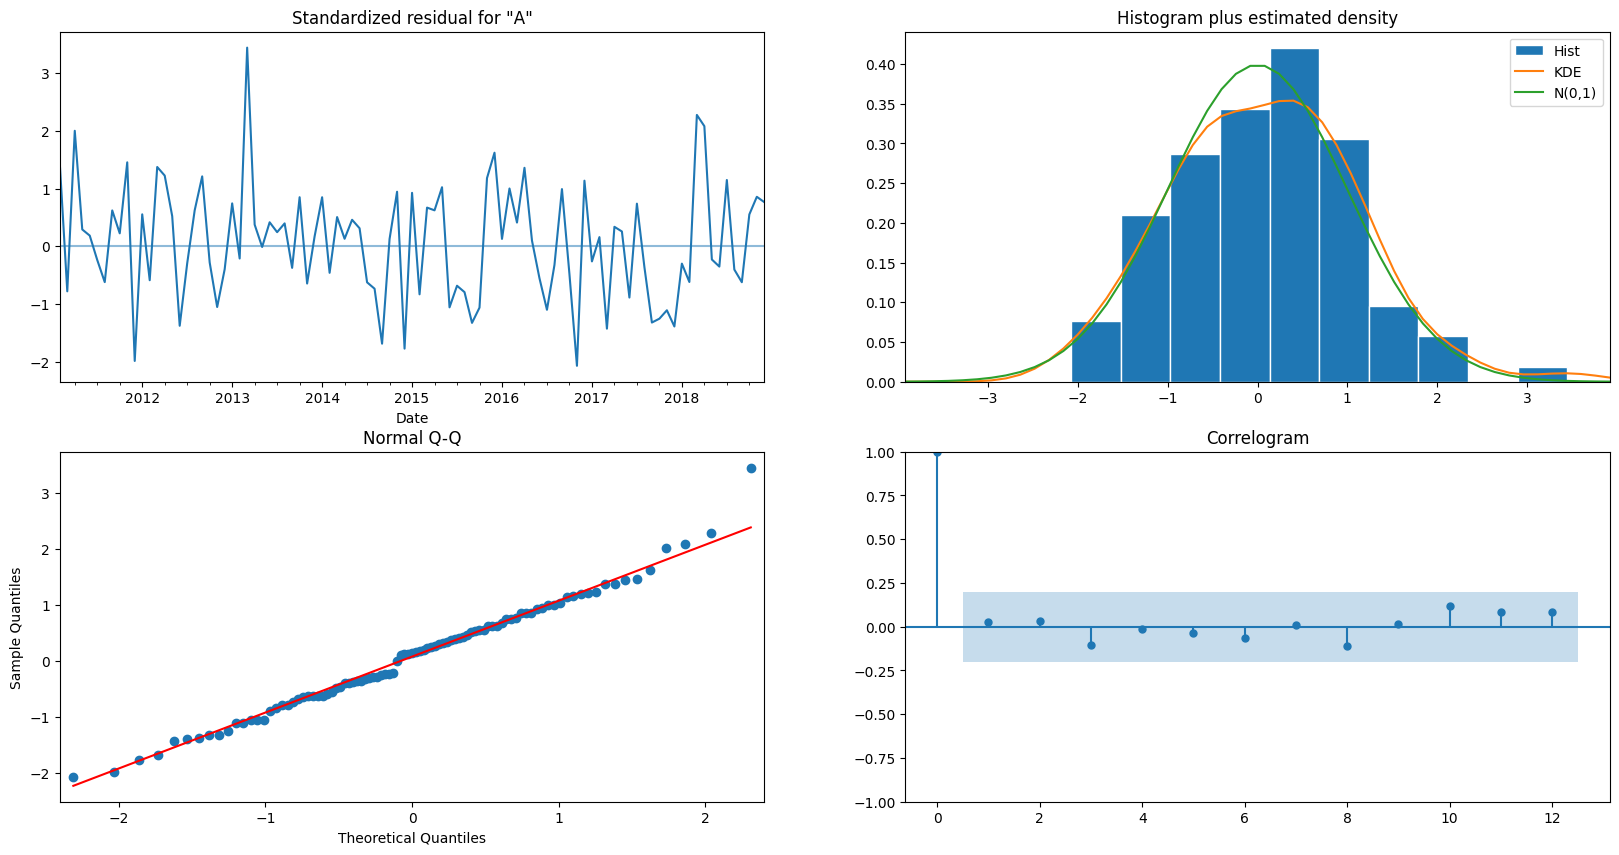

In [13]:
plt.rc("figure",figsize=(20,10))
result.plot_diagnostics(lags=12); #ノイズの確認
# result.plot_diagnostics(lags=12); : ;の部分は必要なのか
# result.plot_diagnostics(lags=12)のコードは、SARIMAモデルの診断プロットを生成するためのものです。
# ;はPythonのコードブロックの終了を示すものではなく、コード行の区切り文字として使用されます。この行末の;はPythonコードの実行には影響を与えません。

# standardized residual: x軸に時系列, y軸がノイズの大きさ, ノイズは時系列の秩序を抜いたものなので、ノイズに周期性が残っているとおかしい(ランダムであってほしい)
# histogram plus estimated density: ノイズの分布, 0に近い方が嬉しい(正規分布に近ければ嬉しい)
# normal Q-Q: 赤線上に青点があったら正規分布としてみなしていいという指標
# correlogram: ノイズのコレログラム(今回の例では周期性はないように見える) -> 時間間隔間で自己相関がほとんどないか、非常に小さければいい



# result.plot_diagnostics(lags=12)は、モデルの診断プロットを生成するためのコードです。
# このプロットを使用して、時系列データの残差（ノイズ）がいくつかの重要な統計的特性を持っているかどうかを確認することができます。
# 主な目的は、ノイズが正規分布に従っているかどうかを確認することです。

# このプロットは以下の要素から構成されています：
# Residuals Plot: 残差のプロットは、残差がランダムに分布しているかどうかを確認するのに役立ちます。ランダムに分布している場合、ノイズが均一であることを示唆します。
# Histogram: 残差のヒストグラムは、残差が正規分布に近似しているかどうかを確認するためのものです。正規分布に近い場合、ヒストグラムはベル型の形状になります。
# QQ Plot (Quantile-Quantile Plot): QQプロットは、残差の分位数と正規分布の分位数を比較します。データが正規分布に従っている場合、QQプロットは直線上に点が配置されます。
# Correlogram (ACF Plot): ACFプロットは、残差の自己相関を確認するのに役立ちます。自己相関がランダムに近い場合、モデルの残差は無相関であると考えられます。

# これらの要素を通じて、ホワイトノイズ仮説に従っているかどうかを確認します。
# ホワイトノイズは、正規分布に従い、ランダムで無相関であると仮定されます。これらの特性が満たされていることは、モデルの適切性を確認するために重要です。



# ホワイトノイズは、正規分布に従い、ランダムで無相関ということがわかればいいのね
# はい、正確です。ホワイトノイズは以下の主要な特性を持っています：
# 正規分布: ホワイトノイズは通常、正規分布（ガウス分布）に従っています。この特性はヒストグラムやQQプロットを通じて確認されます。
# ランダム性: ホワイトノイズはランダムな値から生成されます。つまり、特定のパターンやトレンドが存在しないことが期待されます。
# 無相関性: ホワイトノイズの時間間隔間で自己相関がほとんどないか、非常に小さいことが期待されます。この特性はACFプロット（自己相関関数のプロット）を通じて確認されます。

# ホワイトノイズがこれらの特性を持っている場合、それはランダム性が高く、外部の要因やトレンドが影響を与えていないことを示しています。
# 時系列モデルの残差がホワイトノイズに近い場合、モデルはデータに適合していると見なすことができます。逆に、ホワイトノイズからの明らかな偏差がある場合、モデルの改善が必要かもしれません。

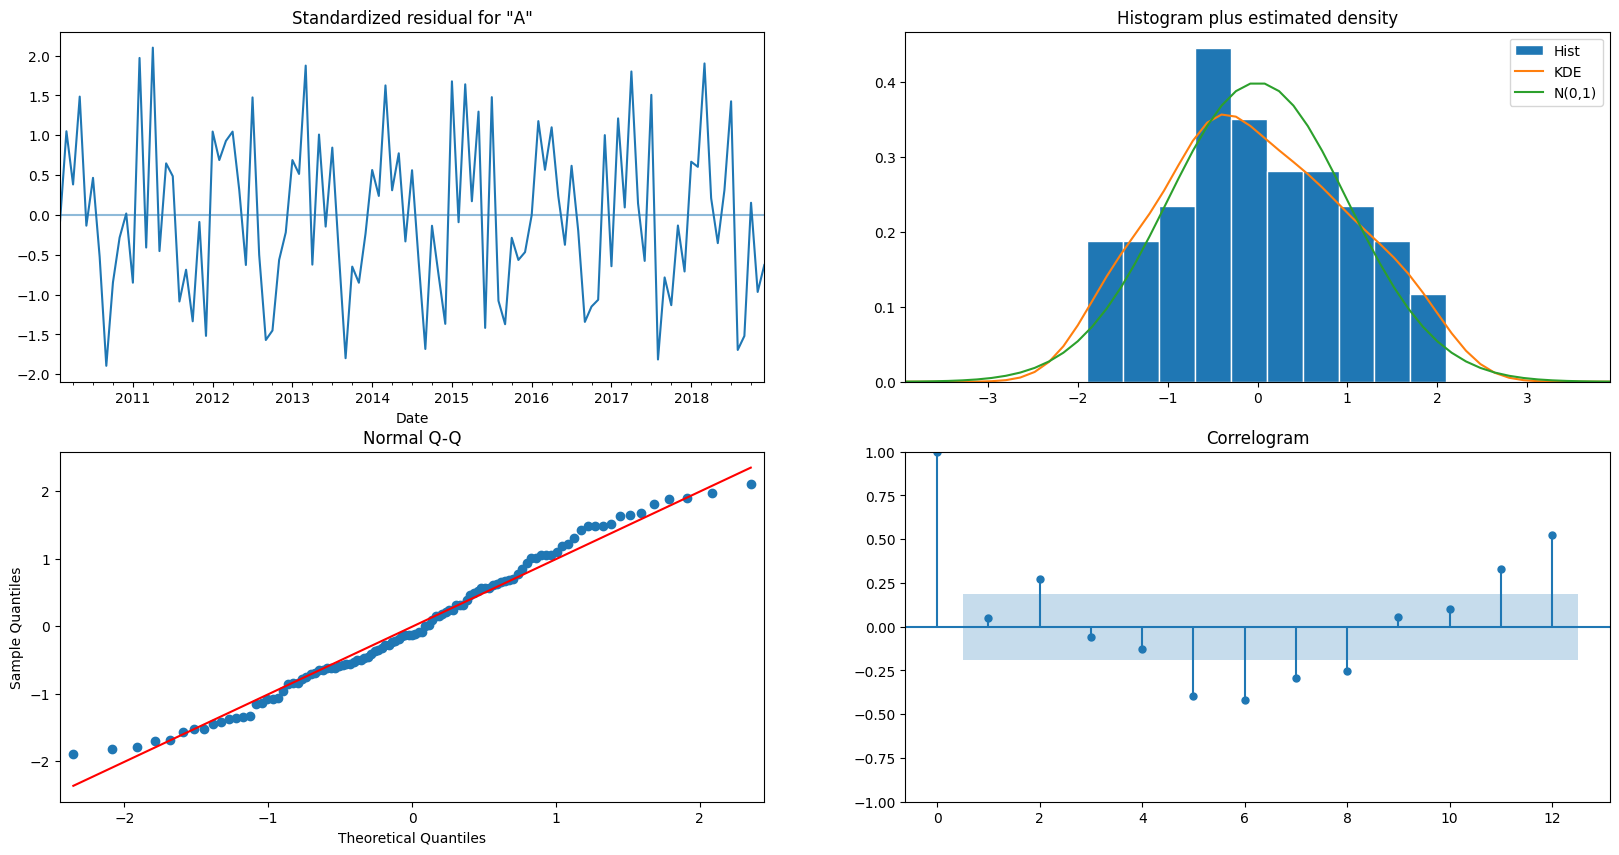

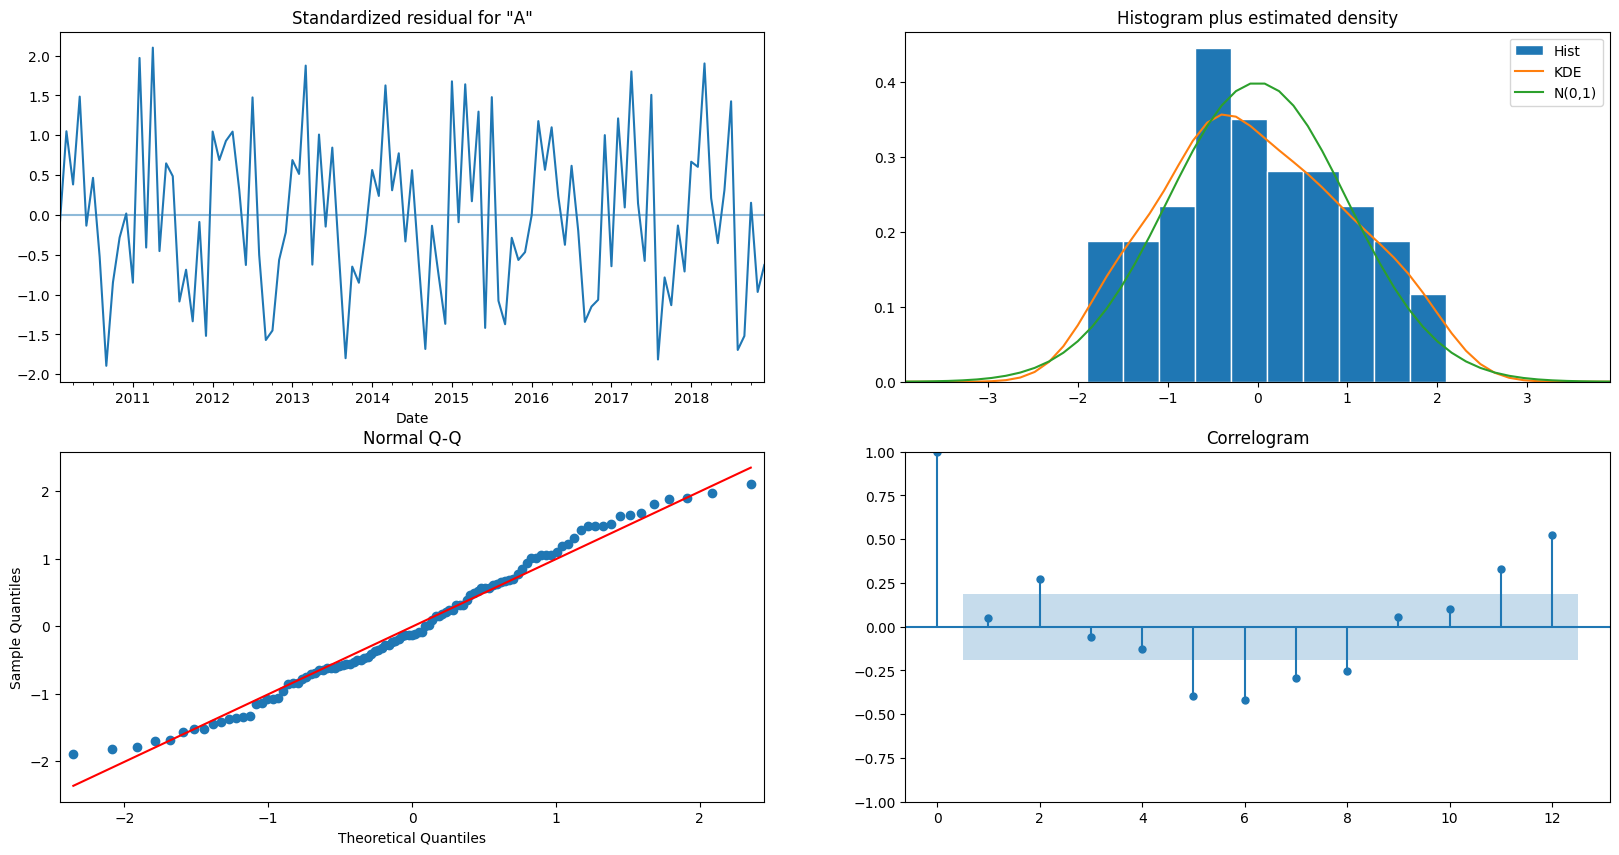

In [14]:
# ARIMAの場合で確認して見る
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = df_month["Average Temperature (℃)"]
sarima_model = sm.tsa.SARIMAX(y, order=(1,1,1))
result = sarima_model.fit()

result.summary()

plt.rc("figure",figsize=(20,10))
result.plot_diagnostics(lags=12)

### 波形の予測(モデリングができた後のついでとして予測ができる)

* 精度順: SARIMAX > SARIMA > ARIMA

2018-12-31     8.115875
2019-01-31     5.516309
2019-02-28     6.085646
2019-03-31    10.043718
2019-04-30    15.302647
2019-05-31    19.855468
2019-06-30    22.232063
2019-07-31    26.995956
2019-08-31    27.389552
2019-09-30    23.335863
2019-10-31    18.411575
2019-11-30    12.969499
2019-12-31     7.873498
Freq: M, Name: predicted_mean, dtype: float64

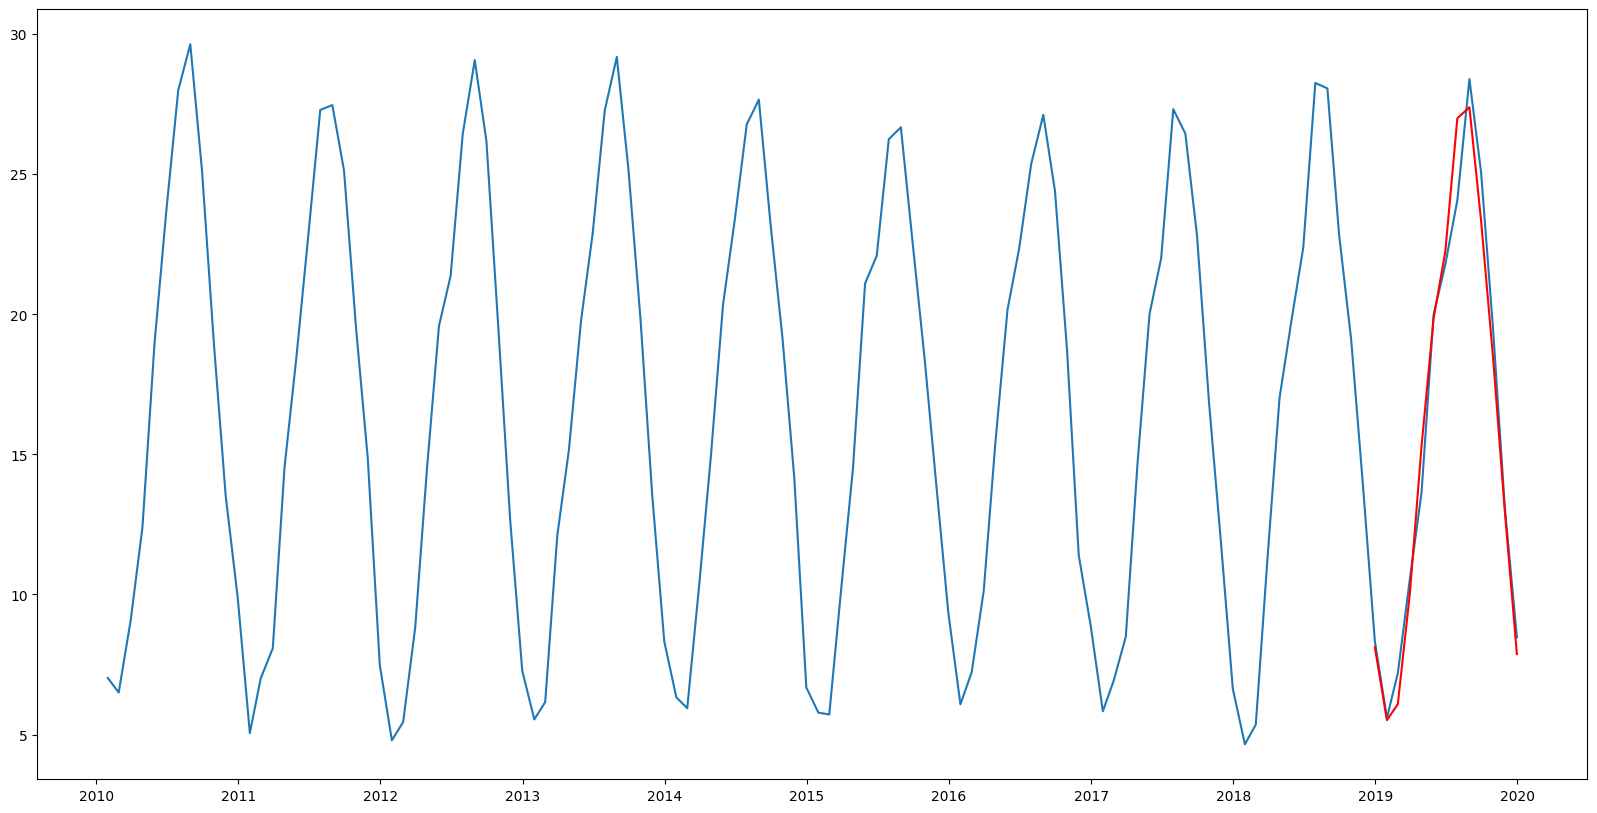

In [15]:
# SARIMA ver
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = df_month["Average Temperature (℃)"]
# X = df_month[["Total Precipitation (mm)","Sunshine Duration (hours)"]] #これがないとSARIMAになる -> あるとSARIMAX(Xという説明変数が追加されるから)
sarima_model = sm.tsa.SARIMAX(y, order=(1,1,1),seasonal_order=(0,1,1,12))  #SARIMAXにする場合はXの変数を入れる必要がある
result = sarima_model.fit()

# bestPred = result(モデル).predict('予測したい期間(開始)', '予測したい期間(終了)',exog=説明変数(SARIMAXの場合に必要))
bestPred = result.predict('2018-12', '2019-12')
plt.plot(df_month_all["Average Temperature (℃)"])
plt.plot(bestPred, "r")

display(bestPred) # 具体的な値が出力される(今回の場合は月ごと)
#青が実測値
#赤が予測値
#まあまあ精度が高い

2018-12-31     7.586144
2019-01-31     5.843564
2019-02-28     5.833777
2019-03-31     9.583489
2019-04-30    14.758162
2019-05-31    19.846090
2019-06-30    22.163755
2019-07-31    25.507267
2019-08-31    27.799522
2019-09-30    23.975418
2019-10-31    18.384238
2019-11-30    13.379997
2019-12-31     7.233139
Freq: M, Name: predicted_mean, dtype: float64

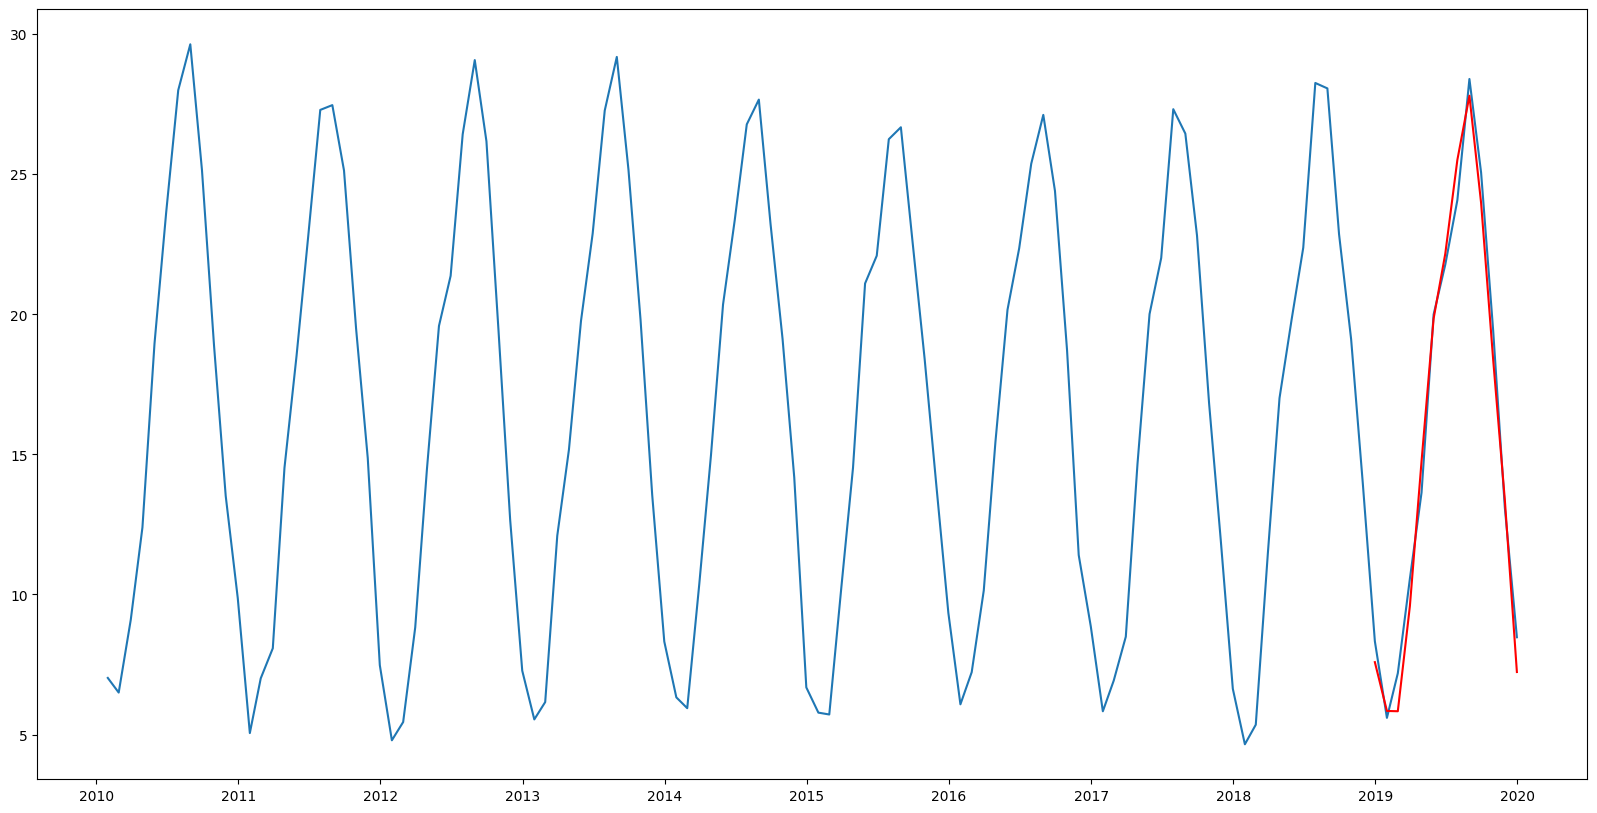

In [16]:
# SARIMAX ver
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = df_month["Average Temperature (℃)"]
X = df_month[["Total Precipitation (mm)","Sunshine Duration (hours)"]] #これがあることでSARIMAXになる
sarima_model = sm.tsa.SARIMAX(y, X, order=(1,1,1),seasonal_order=(0,1,1,12)) #SARIMAXにする場合はXの変数を入れる必要がある
result = sarima_model.fit()

# bestPred = result(モデル).predict('予測したい期間(開始)', '予測したい期間(終了)',exog=説明変数(SARIMAXの場合に必要))
bestPred = result.predict('2018-12', '2019-12',exog = df_month_pred[["Total Precipitation (mm)","Sunshine Duration (hours)"]])
plt.plot(df_month_all["Average Temperature (℃)"])
plt.plot(bestPred, "r")

display(bestPred) # 具体的な値が出力される(今回の場合は月ごと)
# 以下の画像から青線(実際の線)と赤線(予測線)が重複しているため、良い感じに予測できているように思われる, ノイズが乗っているのでブレはある, 精度が高い
# モデル選定が一番時間がかかる

2018-12-31    10.100975
2019-01-31     4.285471
2019-02-28     1.594178
2019-03-31    -0.195651
2019-04-30    -1.385966
2019-05-31    -2.177578
2019-06-30    -2.704035
2019-07-31    -3.054153
2019-08-31    -3.286996
2019-09-30    -3.441848
2019-10-31    -3.544831
2019-11-30    -3.613319
2019-12-31    -3.658866
Freq: M, Name: predicted_mean, dtype: float64

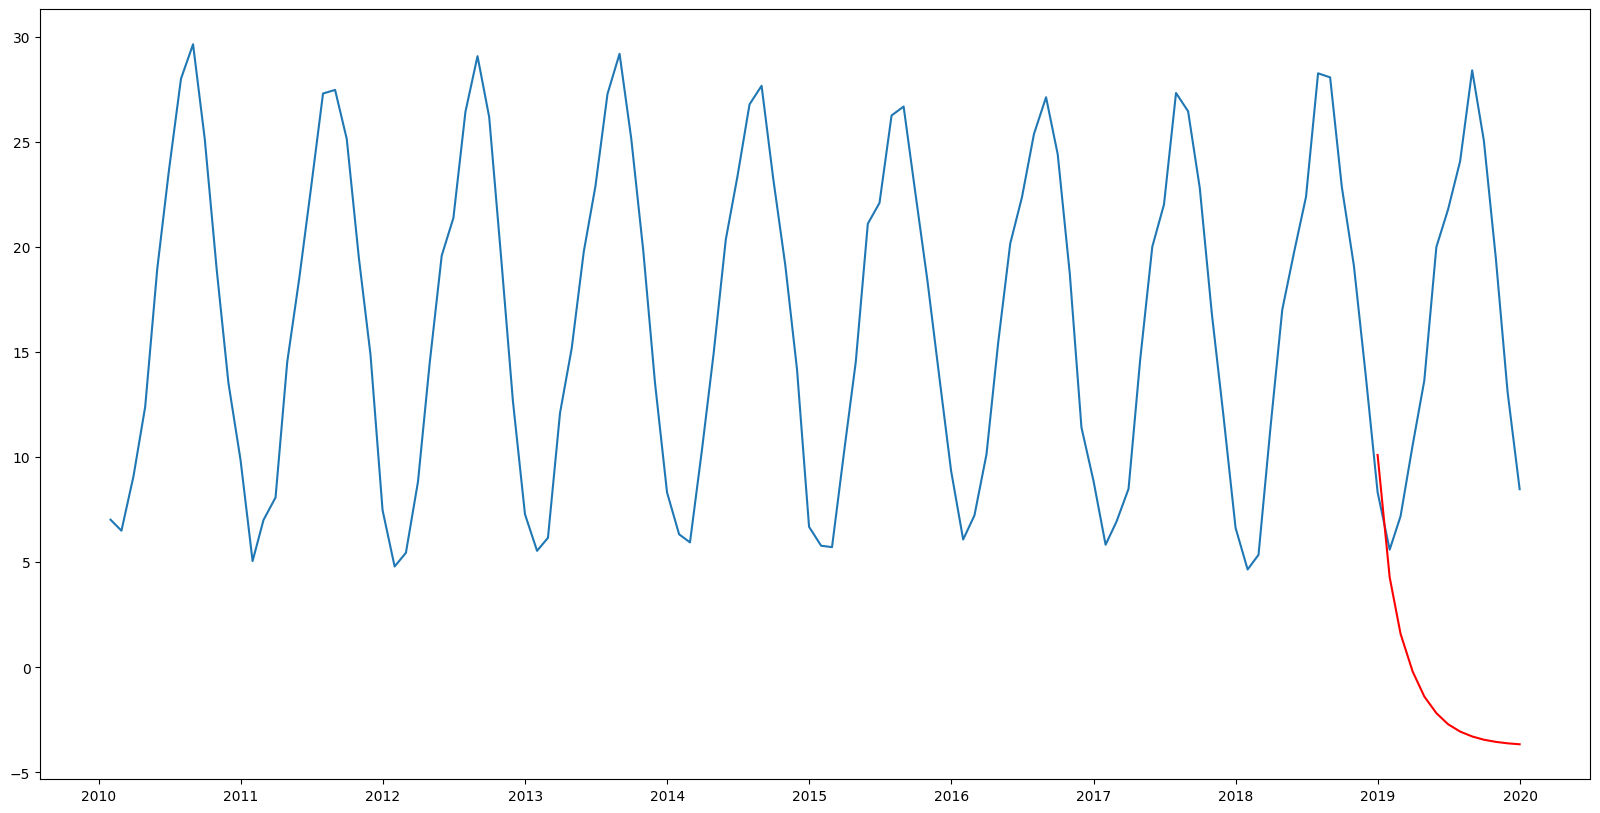

In [17]:
# ARIMA ver
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = df_month["Average Temperature (℃)"]
sarima_model = sm.tsa.SARIMAX(y, order=(1,1,1))
result = sarima_model.fit()

# bestPred = result(モデル).predict('予測したい期間(開始)', '予測したい期間(終了)',exog=説明変数(SARIMAXの場合に必要))
bestPred = result.predict('2018-12', '2019-12')
plt.plot(df_month_all["Average Temperature (℃)"])
plt.plot(bestPred, "r")

display(bestPred) # 具体的な値が出力される(今回の場合は月ごと)

# 精度が低い